In [1]:
import orbitize
from orbitize import driver
import matplotlib.pyplot as plt
import multiprocessing as mp
import warnings
import numpy as np
import pandas as pd
from scipy import stats
warnings.filterwarnings("ignore")

In [2]:
# MCMC parameters
num_walkers = 50
num_threads = mp.cpu_count() # or a different number if you prefer

my_driver = orbitize.driver.Driver('B2-B3-orbitizetab.csv', # path to data file
                                  'MCMC', # name of algorithm for orbit-fitting
                                  1, # number of secondary bodies in system
                                  5.5, # total system mass [M_sun]
                                  2.41, # total parallax of system [mas]
                                  mass_err=0.5, # mass error [M_sun]
                                  plx_err=0.03, # parallax error [mas]
                                  mcmc_kwargs={'num_walkers': num_walkers, 'num_threads': num_threads})

In [3]:
# RUN MCMC
total_orbits = 2e2*num_walkers # number of steps x number of walkers (at lowest temperature)
burn_steps = 2e2 # steps to burn in per walker
thin = 1 # only save every 2nd step

my_driver.sampler.run_sampler(int(total_orbits), burn_steps=int(burn_steps), thin=int(thin))

Starting Burn in


KeyboardInterrupt: 

In [ ]:
#MCMC PLOTS
corner_plot_fig = my_driver.sampler.results.plot_corner() # Creates a corner plot and returns Figure object
# corner_plot_fig.savefig('b2b3_corner_plot.png') # This is matplotlib.figure.Figure.savefig()

In [ ]:
epochs = my_driver.system.data_table['epoch']
orbit_plot_fig = my_driver.sampler.results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 100, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0] # Minimum MJD for colorbar (here we choose first data epoch)
)
# orbit_plot_fig.savefig('b2b3_orbit_plot.png') # This is matplotlib.figure.Figure.savefig()

In [ ]:
sma_chains, ecc_chains = my_driver.sampler.examine_chains(param_list=['sma1','ecc1'], n_walkers=5)

In [ ]:
# save result as hdf5
hdf5_filename='my_posterior_lab.hdf5'
import os
# To avoid weird behaviours, delete saved file if it already exists from a previous run of this notebook
if os.path.isfile(hdf5_filename):
    os.remove(hdf5_filename)
my_driver.sampler.results.save_results(hdf5_filename)

In [ ]:
# # save orbits result as csv
# import pandas as pd
# data = myResults.post
# df = pd.DataFrame(data, columns=myResults.labels)
# df.to_csv('test.csv')

In [4]:
# load in saved hdf5 result
hdf5_filename='my_posterior_lab2.hdf5'
from orbitize import results
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(hdf5_filename)

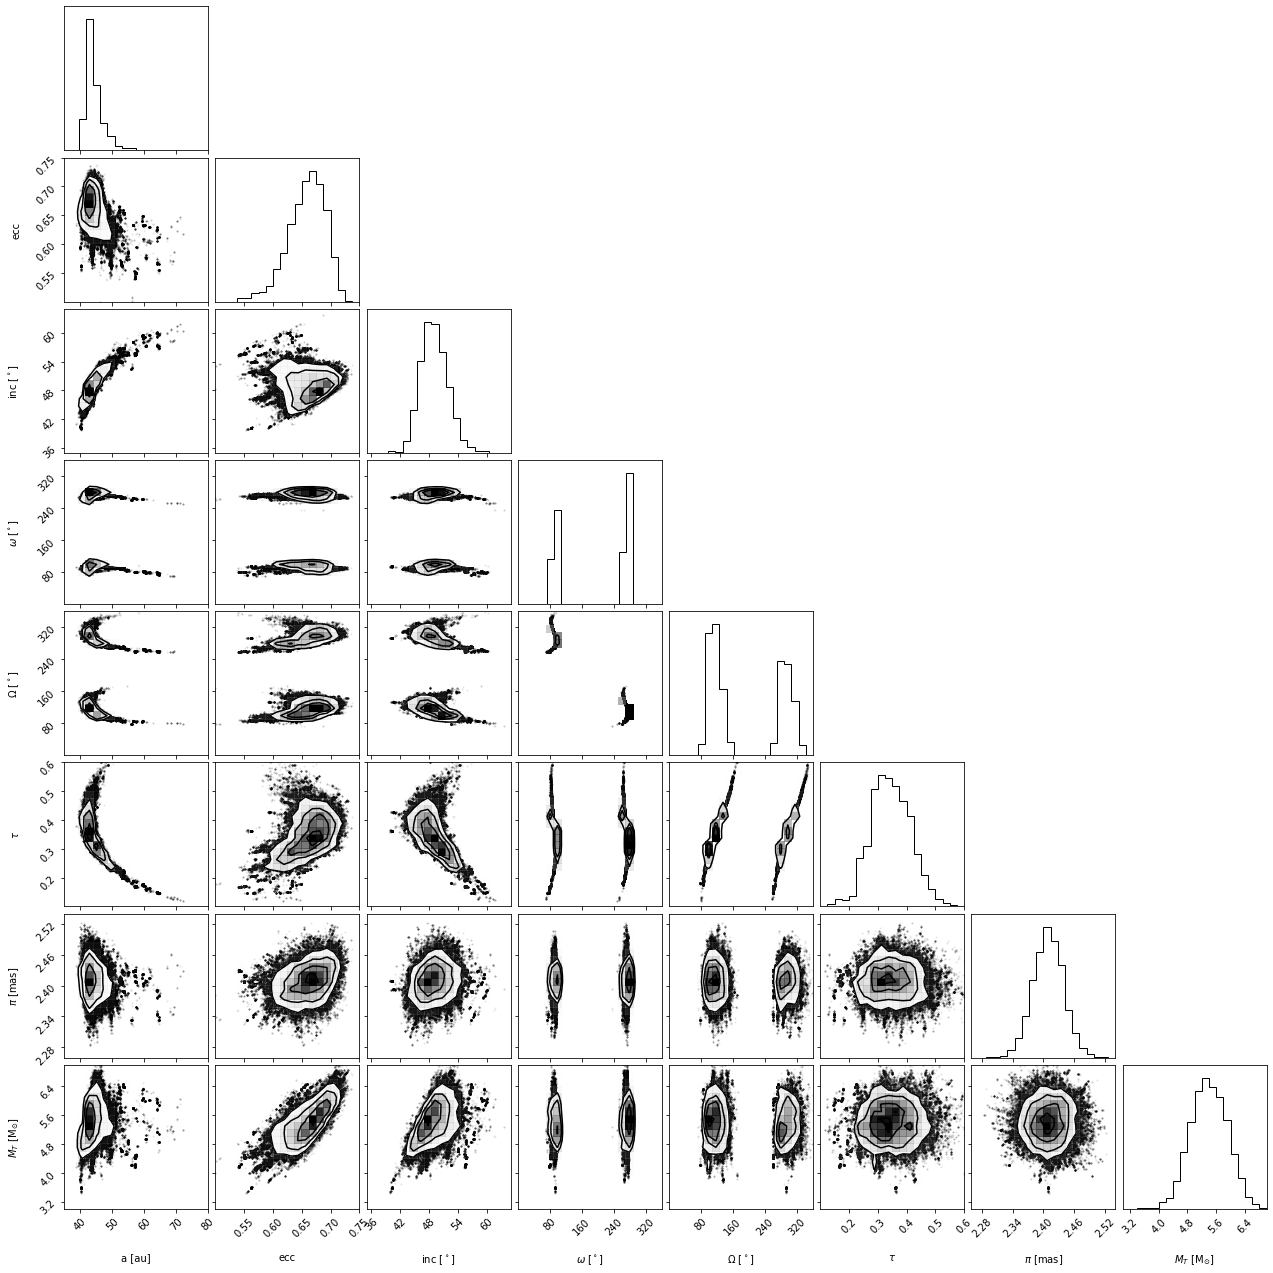

In [11]:
#MCMC PLOTS
range_values = [(35,80),(0.5,0.75),(35,65),(0, 360),(0,360),(0.1,0.6),(2.26,2.54),(3.0,7.0)]
corner_plot_fig = loaded_results.plot_corner(
    range=range_values,
) # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('b2b3_corner_plot.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

In [5]:
results = pd.read_csv(
    'visao_b2-b3 2.csv',
    header = 0,
    sep = ',',
    usecols = lambda x:x in ["Date", "med sep", "med PA", "stdev sep", "stdev PA"],
    nrows = 9
)

for pa_i in range(len(results['med PA'])):
    pa = results['med PA'][pa_i]
    if pa < 90:
        results['med PA'][pa_i] += 180

In [6]:
import datetime
results['datetime'] = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in results['Date']]
results['epoch'] = [(x-results.datetime[0]).days for x in results.datetime]
from astropy.time import Time
results['MJD'] = [Time(x, format='datetime').mjd for x in results['datetime']]

outtable = pd.DataFrame()
outtable['epoch'] = results['MJD']
outtable['object'] = np.zeros(len(results))+1
outtable['sep'] = results['med sep']
outtable['sep_err'] = results['stdev sep']
outtable['pa'] = results['med PA']
outtable['pa_err'] = results['stdev PA']
outtable.to_csv('visao-b2b3-orbitizelike.csv', index=False)
outtable

,epoch,object,sep,sep_err,pa,pa_err
0,56388.0,1.0,14.724274,0.107122,222.701469,0.388696
1,56389.0,1.0,14.549567,0.098303,222.511326,0.177892
2,56990.0,1.0,14.789035,0.277050,225.203971,3.306293
3,57367.0,1.0,15.121239,0.458726,227.134512,1.793952
4,57709.0,1.0,14.617388,0.036466,226.681237,0.015062
5,57788.0,1.0,14.484011,0.052299,226.690009,0.165388
6,57790.0,1.0,14.457903,0.038578,226.877635,0.047179
7,57798.0,1.0,14.491549,0.061778,226.815344,0.318754
8,58234.0,1.0,14.541079,0.126381,228.321249,0.056525


In [7]:
outtable['pa_default'] = outtable['pa']-0.59
outtable['sep_default'] = outtable['sep']*7.9
outtable['pa_err_default'] = np.sqrt(((outtable['pa_err'])**2)+((0.3)**2))
outtable['sep_err_default'] = outtable['sep_default']*np.sqrt(((outtable['sep_err']/outtable['sep'])**2)+((0.02/7.9)**2))
outtable.head()

,epoch,object,sep,sep_err,pa,pa_err,pa_default,sep_default,pa_err_default,sep_err_default
0,56388.0,1.0,14.724274,0.107122,222.701469,0.388696,222.111469,116.321765,0.491003,0.896041
1,56389.0,1.0,14.549567,0.098303,222.511326,0.177892,221.921326,114.941580,0.348777,0.829319
2,56990.0,1.0,14.789035,0.277050,225.203971,3.306293,224.613971,116.833379,3.319875,2.208592
3,57367.0,1.0,15.121239,0.458726,227.134512,1.793952,226.544512,119.457790,1.818863,3.636535
4,57709.0,1.0,14.617388,0.036466,226.681237,0.015062,226.091237,115.477368,0.300378,0.410436


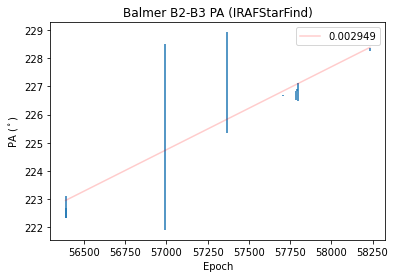

In [8]:
# my result
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], outtable['pa'])
plt.errorbar(outtable['epoch'], outtable['pa'], yerr=outtable['pa_err'], ls='none')
plt.plot(outtable['epoch'], intercept + slope*outtable['epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
#plt.xlim(-500, 6700)
plt.title('Balmer B2-B3 PA (IRAFStarFind)')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
plt.savefig('visao_pa.png', dpq=200)

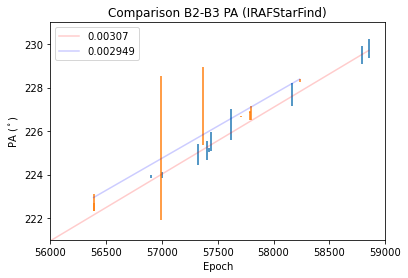

In [9]:
# compare to NIRC2
nircast = pd.read_csv('B2-B3-orbitizetab.csv')

slope, intercept, r_value, p_value, std_err = stats.linregress(nircast['epoch'], nircast['pa'])
plt.errorbar(nircast['epoch'], nircast['pa'], yerr=nircast['pa_err'], ls='none')
plt.plot(nircast['epoch'], intercept + slope*nircast['epoch'], 'r', alpha=0.2, label=round(slope,6))

slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], outtable['pa'])
plt.errorbar(outtable['epoch'], outtable['pa'], yerr=outtable['pa_err'], ls='none')
plt.plot(outtable['epoch'], intercept + slope*outtable['epoch'], 'b', alpha=0.2, label=round(slope,6))

plt.legend()
plt.xlim(56000, 59000)
plt.ylim(221,231)
plt.title('Comparison B2-B3 PA (IRAFStarFind)')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
plt.savefig('visao_pa_compare.png', dpq=200)

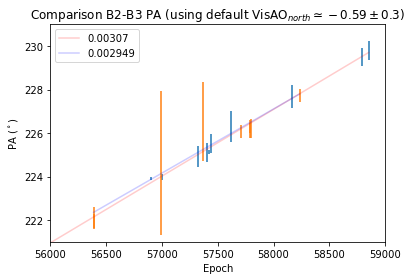

In [10]:
# compare if using default VisAO_north
nircast = pd.read_csv('B2-B3-orbitizetab.csv')

slope, intercept, r_value, p_value, std_err = stats.linregress(nircast['epoch'], nircast['pa'])
plt.errorbar(nircast['epoch'], nircast['pa'], yerr=nircast['pa_err'], ls='none')
plt.plot(nircast['epoch'], intercept + slope*nircast['epoch'], 'r', alpha=0.2, label=round(slope,6))

slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], outtable['pa_default'])
plt.errorbar(outtable['epoch'], outtable['pa_default'], yerr=outtable['pa_err_default'], ls='none')
plt.plot(outtable['epoch'], intercept + slope*outtable['epoch'], 'b', alpha=0.2, label=round(slope,6))

plt.legend()
plt.xlim(56000, 59000)
plt.ylim(221,231)
plt.title(r'Comparison B2-B3 PA (using default VisAO$_{north}\simeq-0.59\pm0.3$)')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
plt.savefig('visao_pa_compare_default.png', dpq=200)

In [12]:
# positions for magao data

# semimajor axis 1, eccentricity 1, inclination 1,
# argument of periastron 1, position angle of nodes 1,
# epoch of periastron passage 1
data = loaded_results.post
JDs = outtable['epoch']
sma = data[:, 0]
ecc = data[:, 1]
inc = data[:, 2]
aop = data[:, 3]
pan = data[:, 4]
tau = data[:, 5]
mtot = 5.5
plx = 2.41
ra, dec, vz = orbitize.kepler.calc_orbit(JDs, sma, ecc, inc, aop, pan, tau, plx, mtot, tau_ref_epoch=loaded_results.tau_ref_epoch)

In [13]:
from scipy import stats
seps, pas = orbitize.system.radec2seppa(ra, dec)

exp_seps = np.zeros((seps.shape[0]))
exp_sep_errs = np.zeros((seps.shape[0]))
exp_pas = np.zeros((seps.shape[0]))
exp_pa_errs = np.zeros((seps.shape[0]))
for epoch in range(len(exp_seps)):
    sep_ep = np.median(seps[epoch])
    sep_ep_Err = np.std(seps[epoch])
    exp_seps[epoch] = sep_ep
    exp_sep_errs[epoch] = sep_ep_Err
    pa_ep = np.median(pas[epoch])
    exp_pas[epoch] = pa_ep
    pa_ep_Err = np.std(pas[epoch])
    exp_pa_errs[epoch] = pa_ep_Err

In [14]:
from astropy.time import Time
epochs_yr = Time(outtable['epoch'], format='mjd').decimalyear
epochs_yr_nirc = Time(nircast['epoch'], format='mjd').decimalyear
pa = outtable['pa']; pa_err = outtable['pa_err']

visP = pa
visPe = pa_err

kekS = exp_seps
kekSe = exp_sep_errs
kekP = exp_pas
kekPe = exp_pa_errs

kekDF = pd.DataFrame(columns=['epoch', 'sep', 'seperr', 'pa', 'paerr'])
kekDF['epoch'] = epochs_yr
kekDF['sep'] = kekS
kekDF['seperr'] = kekSe
kekDF['pa'] = kekP
kekDF['paerr'] = kekPe
kekDF.head()

,epoch,sep,seperr,pa,paerr
0,2013.260274,115.929398,1.426057,221.930526,0.388068
1,2013.263014,115.929047,1.426053,221.933755,0.387914
2,2014.909589,115.677418,1.422481,223.895222,0.295998
3,2015.942466,115.483344,1.419543,225.131280,0.239099
4,2016.877049,115.282706,1.416425,226.256675,0.188654


<Figure size 1008x432 with 0 Axes>

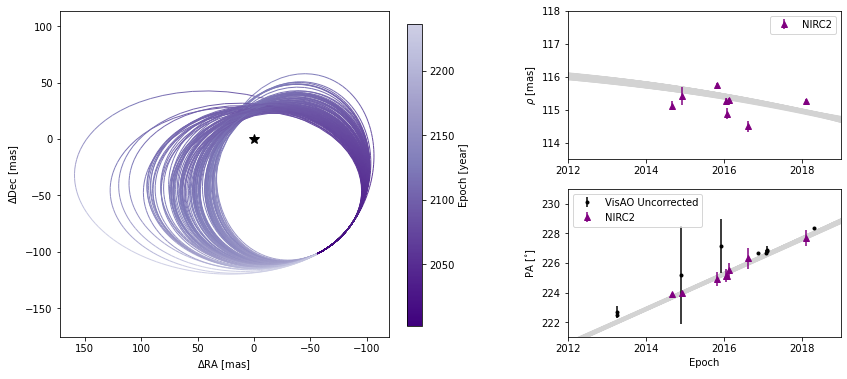

In [15]:
epochs = my_driver.system.data_table['epoch']

orb_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 100, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=False,
    data = my_driver.system.data_table
)

ax_orb, ax_sep, ax_pa, ax_cbar  = orb_fig.axes



# grab data from Driver object
data_tab = my_driver.system.data_table

# # add data to sep panel
# ax_sep.errorbar(
#     epochs_yr, visS, visSe,
#     color='black', linestyle='', fmt='o', zorder=3, label='VisAO Uncorrected', markersize=3
# )

# add data to PA panel
ax_pa.errorbar(
    epochs_yr, visP, visPe,
    color='black', linestyle='', fmt='o', zorder=3, label='VisAO Uncorrected', markersize=3
)

# add expected pos to sep panel
ax_sep.errorbar(
    epochs_yr_nirc, nircast['sep'], nircast['sep_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

# add expected pos to PA panel
ax_pa.errorbar(
    epochs_yr_nirc, nircast['pa'], nircast['pa_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

ax_orb.plot(0,0,marker="*",color='black',markersize=10)
ax_sep.legend()
ax_pa.legend()

# zoom in a bit
ax_sep.set_xlim(2012,2019)
ax_pa.set_xlim(2012,2019)
ax_sep.set_ylim(113.5,118)
ax_pa.set_ylim(221,231)

orb_fig.savefig('b2b3_uncorrected.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

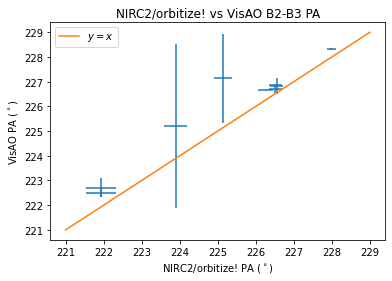

In [16]:
plt.errorbar(x=kekP, y=visP, xerr=kekPe, yerr=visPe, ls='none')
plt.plot([221,229],[221,229], label=r'$y=x$')
plt.title('NIRC2/orbitize! vs VisAO B2-B3 PA')
plt.legend()
plt.xlabel(r'NIRC2/orbitize! PA ($^\circ$)')
plt.ylabel(r'VisAO PA ($^\circ$)')
plt.savefig('visao_pa_compare_uncorrected.png', dpq=200)

In [17]:
import numpy as np
import matplotlib.pyplot as plt


import random

# Initiate some data, giving some randomness using random.random().
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([i**2 + random.random() for i in x])

x_err = np.array([random.random() for i in x])
y_err = np.array([random.random() for i in x])

# Define a function to fit the data with.
def lin_func(p, x):
    m, c = p
    return m*x + b

# Create a model for fitting.
quad_model = Model(quad_func)

# Create a RealData object using our initiated data from above.
data = RealData(x, y, sx=x_err, sy=y_err)

# Set up ODR with the model and data.
odr = ODR(data, quad_model, beta0=[0., 1.])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()
'''Beta: [ 1.01781493  0.48498006]
Beta Std Error: [ 0.00390799  0.03660941]
Beta Covariance: [[ 0.00241322 -0.01420883]
 [-0.01420883  0.21177597]]
Residual Variance: 0.00632861634898189
Inverse Condition #: 0.4195196193536024
Reason(s) for Halting:
  Sum of squares convergence'''

x_fit = np.linspace(x[0], x[-1], 1000)
y_fit = quad_func(out.beta, x_fit)

plt.errorbar(x, y, xerr=x_err, yerr=y_err, linestyle='None', marker='x')
plt.plot(x_fit, y_fit)

plt.show()

NameError: name 'Model' is not defined

0.1253336393174972


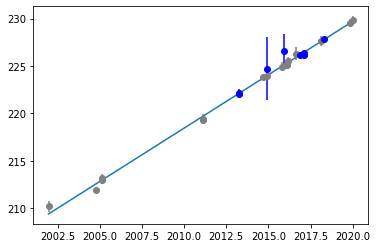

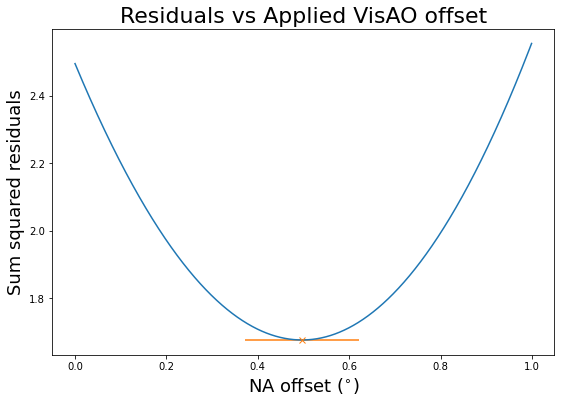

In [62]:
import numpy as np
from scipy.odr import *
# slope, intercept, r_value, p_value, std_err = stats.linregress(nircast['epoch'], nircast['pa'])
residuals = []
for i in np.arange(0, 1, 0.001):
    visP_new = visP-i
    kekP_orig = nircast['pa']
    kekPe_orig = nircast['pa_err']
    allP = np.append(visP_new, kekP_orig)
    allerr = np.append(visPe, kekPe_orig)
    allyr = np.append(epochs_yr, epochs_yr_nirc)
    
    # linear regression accounting for errorbars on y
    x = allyr
    y = allP
    y_err = allerr
    
    # Define a function to fit the data with.
    def lin_func(p, x):
        m, b = p
        return m*x + b

    # Create a model for fitting.
    lin_model = Model(lin_func)

    # Create a RealData object using our initiated data from above.
    data = RealData(x, y, sy=y_err)

    # Set up ODR with the model and data.
    odr = ODR(data, lin_model, beta0=[0., 1.])

    # Run the regression.
    out = odr.run()
    

    # Use the in-built pprint method to give us results.
    residuals.append((i, out.sum_square))
    
    if i == 0.497:        
        x_fit = np.linspace(x.min(), x.max(), 1000)
        y_fit = lin_func(out.beta, x_fit)
        points_y_fit = lin_func(out.beta, epochs_yr)
        visresid = visP_new-points_y_fit
        from statsmodels.stats.weightstats import DescrStatsW
        wstats = DescrStatsW(visresid, 1/visPe, ddof=0)
        best_fit_err = wstats.std
        print(best_fit_err)
        plt.errorbar(epochs_yr_nirc, nircast['pa'], yerr=nircast['pa_err'], linestyle='None', marker='o', color='grey')
        plt.errorbar(epochs_yr, visP_new, yerr=visPe, linestyle='None', marker='o', color='blue')
        plt.plot(x_fit, y_fit)
        plt.savefig('quick_min_resid_fit.png')
        
pa_resid_arr = np.array(residuals)
best_pa_off = pa_resid_arr[pa_resid_arr[:,1] == pa_resid_arr[:,1].min()]
plt.figure(figsize=(9,6))
plt.plot(pa_resid_arr[:,0], pa_resid_arr[:,1])
plt.errorbar(best_pa_off[:,0][0], best_pa_off[:,1][0], xerr=best_fit_err, marker='x')
plt.title('Residuals vs Applied VisAO offset', fontsize=22)
plt.xlabel(r'NA offset ($^{\circ}$)', fontsize=18)
plt.ylabel('Sum squared residuals', fontsize=18)
plt.savefig('NAoff_resids.png', dpi=200)
# plt.vlines(best_pa_off[:,0], ymin=1.5, ymax=2.5)

In [60]:
best_pa_off[:,1][0]

1.6763397493987868

0.1253336393174972

In [105]:
# for mult/div fractional uncertainties add in quad
# for add/sub uncertainties add in quad
# least squares min on each point 
outtable['platescale'] = kekS/outtable['sep']
outtable['platescale_err'] = outtable['platescale']*np.sqrt(((outtable['sep_err']/outtable['sep'])**2)+((kekSe/kekS)**2))

outtable['pa_offset'] = outtable['pa']-kekP
outtable['pa_offset_err'] = np.sqrt(((outtable['pa_err'])**2)+((kekPe)**2))

In [106]:
outtable['pa_expected'] = outtable['pa']-outtable['pa_offset']
outtable['sep_expected'] = outtable['sep']*outtable['platescale']
outtable['pa_err_expected'] = np.sqrt(((outtable['pa_err'])**2)+((outtable['pa_offset_err'])**2))
outtable['sep_err_expected'] = outtable['sep_expected']*np.sqrt(((outtable['sep_err']/outtable['sep'])**2)+((outtable['platescale_err']/outtable['platescale'])**2))
outtable.head()

,epoch,object,sep,sep_err,pa,pa_err,pa_default,sep_default,pa_err_default,sep_err_default,platescale,platescale_err,pa_offset,pa_offset_err,pa_expected,sep_expected,pa_err_expected,sep_err_expected
0,56388.0,1.0,14.724274,0.107122,222.701469,0.388696,222.111469,116.321765,0.491003,0.896041,7.873352,0.112522,0.770943,0.549255,221.930526,115.929398,0.672878,1.859121
1,56389.0,1.0,14.549567,0.098303,222.511326,0.177892,221.921326,114.941580,0.348777,0.829319,7.967869,0.111825,0.577571,0.426759,221.933755,115.929047,0.462351,1.805721
2,56990.0,1.0,14.789035,0.277050,225.203971,3.306293,224.613971,116.833379,3.319875,2.208592,7.821837,0.175279,1.308750,3.319516,223.895222,115.677418,4.685163,3.378697
3,57367.0,1.0,15.121239,0.458726,227.134512,1.793952,226.544512,119.457790,1.818863,3.636535,7.637161,0.249982,2.003232,1.809815,225.131280,115.483344,2.548273,5.153859
4,57709.0,1.0,14.617388,0.036466,226.681237,0.015062,226.091237,115.477368,0.300378,0.410436,7.886683,0.098877,0.424562,0.189254,226.256675,115.282706,0.189853,1.473663


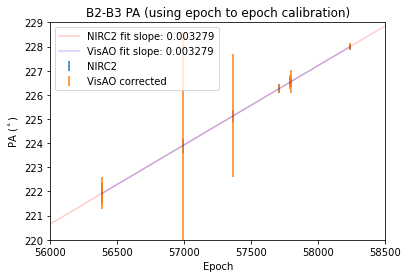

In [107]:
# compare using epoch to epoch offsets
nircast = pd.read_csv('B2-B3-orbitizetab.csv')

slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], kekP)
plt.errorbar(outtable['epoch'], kekP, yerr=kekPe, ls='none', label='NIRC2')
label = 'NIRC2 fit slope: '+str(round(slope,6))
plt.plot(nircast['epoch'], intercept + slope*nircast['epoch'], 'r', alpha=0.2, label=label)

slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], outtable['pa_expected'])
plt.errorbar(outtable['epoch'], outtable['pa_expected'], yerr=outtable['pa_err_expected'], ls='none', label='VisAO corrected')
label = 'VisAO fit slope: '+str(round(slope,6))
plt.plot(outtable['epoch'], intercept + slope*outtable['epoch'], 'b', alpha=0.2, label=label)

plt.legend()
plt.xlim(56000, 58500)
plt.ylim(220,229)
plt.title(r'B2-B3 PA (using epoch to epoch calibration)')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
plt.savefig('visao_pa_compare_ep2ep.png', dpq=200)

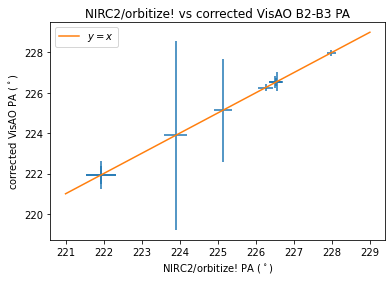

In [108]:
plt.errorbar(x=kekP, y=outtable['pa_expected'], xerr=kekPe, yerr=outtable['pa_err_expected'], ls='none')
plt.plot([221,229],[221,229], label=r'$y=x$')
plt.title('NIRC2/orbitize! vs corrected VisAO B2-B3 PA')
plt.legend()
plt.xlabel(r'NIRC2/orbitize! PA ($^\circ$)')
plt.ylabel(r'corrected VisAO PA ($^\circ$)')
plt.savefig('visao_pa_compare_corrected.png', dpq=200)

In [109]:
outtable['pa_newdef'] = outtable['pa']-0.981
outtable['sep_newdef'] = outtable['sep']*7.94
outtable['pa_err_newdef'] = np.sqrt(((outtable['pa_err'])**2)+((0.387)**2))
outtable['sep_err_newdef'] = outtable['sep_newdef']*np.sqrt(((outtable['sep_err']/outtable['sep'])**2)+((0.11/7.94)**2))

<Figure size 1008x432 with 0 Axes>

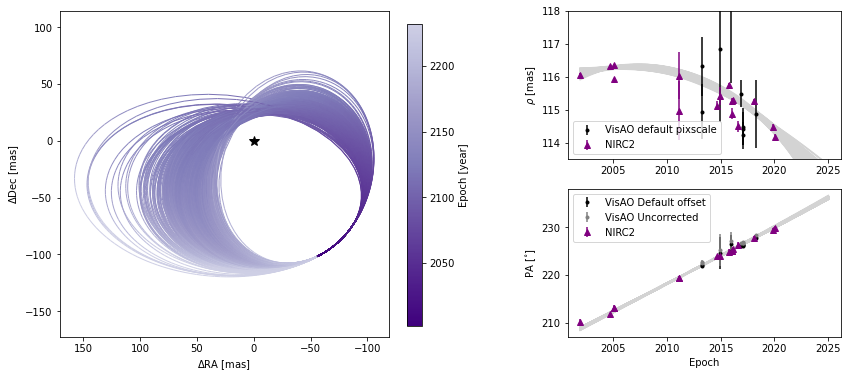

In [174]:
epochs = my_driver.system.data_table['epoch']

orb_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 500, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=False,
    data = my_driver.system.data_table
)

ax_orb, ax_sep, ax_pa, ax_cbar  = orb_fig.axes

from astropy.time import Time

# grab data from Driver object
data_tab = my_driver.system.data_table

epochs_yr = Time(outtable['epoch'], format='mjd').decimalyear

# add data to sep panel
ax_sep.errorbar(
    epochs_yr, outtable['sep_default'], outtable['sep_err_default'],
    color='black', linestyle='', fmt='o', markersize=3, zorder=3, label='VisAO default pixscale'
)

# add data to PA panel
ax_pa.errorbar(
    epochs_yr, outtable['pa_default'], outtable['pa_err_default'],
    color='black', linestyle='', fmt='o', markersize=3, zorder=3, label='VisAO Default offset'
)

# add uncorrected data to PA panel
ax_pa.errorbar(
    epochs_yr, visP, visPe,
    color='grey', linestyle='', fmt='o', zorder=3, label='VisAO Uncorrected', markersize=3
)

# add expected pos to sep panel
ax_sep.errorbar(
    epochs_yr_nirc, nircast['sep'], nircast['sep_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

# add expected pos to PA panel
ax_pa.errorbar(
    epochs_yr_nirc, nircast['pa'], nircast['pa_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

ax_orb.plot(0,0,marker="*",color='black',markersize=10)
ax_sep.legend()
ax_pa.legend()

# zoom in a bit
# ax_sep.set_xlim(2012,2019)
# ax_pa.set_xlim(2012,2019)
ax_sep.set_ylim(113.5,118)
# ax_pa.set_ylim(220,229)

orb_fig.savefig('b2b3_visao_default.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

<Figure size 1008x432 with 0 Axes>

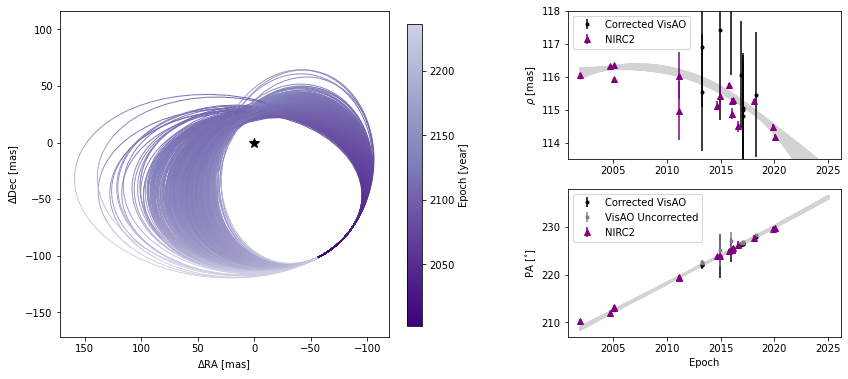

In [128]:
epochs = my_driver.system.data_table['epoch']

orb_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 500, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=False,
    data = my_driver.system.data_table
)

ax_orb, ax_sep, ax_pa, ax_cbar  = orb_fig.axes

from astropy.time import Time

# grab data from Driver object
data_tab = my_driver.system.data_table

epochs_yr = Time(outtable['epoch'], format='mjd').decimalyear

# add data to sep panel
ax_sep.errorbar(
    epochs_yr, outtable['sep_newdef'], outtable['sep_err_newdef'],
    color='black', linestyle='', fmt='o', markersize=3, zorder=3, label='Corrected VisAO'
)

# add data to PA panel
ax_pa.errorbar(
    epochs_yr, outtable['pa_expected'], outtable['pa_err_expected'],
    color='black', linestyle='', fmt='o', markersize=3, zorder=3, label='Corrected VisAO'
)

# add uncorrected data to PA panel
ax_pa.errorbar(
    epochs_yr, visP, visPe,
    color='grey', linestyle='', fmt='o', zorder=3, label='VisAO Uncorrected', markersize=3
)

# add expected pos to sep panel
ax_sep.errorbar(
    epochs_yr_nirc, nircast['sep'], nircast['sep_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

# add expected pos to PA panel
ax_pa.errorbar(
    epochs_yr_nirc, nircast['pa'], nircast['pa_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

ax_orb.plot(0,0,marker="*",color='black',markersize=10)
ax_sep.legend()
ax_pa.legend()

# zoom in a bit
# ax_sep.set_xlim(2012,2019)
# ax_pa.set_xlim(2012,2019)
ax_sep.set_ylim(113.5,118)
# ax_pa.set_ylim(220,229)

orb_fig.savefig('b2b3_corrected.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

# plot with DeRosa astrometry + errorbars (are they too small?)
# 

In [129]:
outtable.to_clipboard()

In [112]:
newpa = 0.41
newpa_err = 0.11
newplate = 7.91
newplate_err = 0.11
outtable['pa_newdef'] = outtable['pa']-newpa
outtable['sep_newdef'] = outtable['sep']*newplate
outtable['pa_err_newdef'] = np.sqrt(((outtable['pa_err'])**2)+((newpa_err)**2))
outtable['sep_err_newdef'] = outtable['sep_newdef']*np.sqrt(((outtable['sep_err']/outtable['sep'])**2)+((newsep_err/newsep)**2))

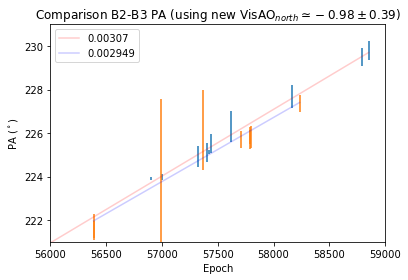

In [113]:
# compare if using default VisAO_north
nircast = pd.read_csv('B2-B3-orbitizetab.csv')

slope, intercept, r_value, p_value, std_err = stats.linregress(nircast['epoch'], nircast['pa'])
plt.errorbar(nircast['epoch'], nircast['pa'], yerr=nircast['pa_err'], ls='none')
plt.plot(nircast['epoch'], intercept + slope*nircast['epoch'], 'r', alpha=0.2, label=round(slope,6))

slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], outtable['pa_newdef'])
plt.errorbar(outtable['epoch'], outtable['pa_newdef'], yerr=outtable['pa_err_newdef'], ls='none')
plt.plot(outtable['epoch'], intercept + slope*outtable['epoch'], 'b', alpha=0.2, label=round(slope,6))

plt.legend()
plt.xlim(56000, 59000)
plt.ylim(221,231)
plt.title(r'Comparison B2-B3 PA (using new VisAO$_{north}\simeq-0.98\pm0.39$)')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
plt.savefig('visao_pa_compare_newdefault.png', dpq=200)

In [114]:
outtable['yr'] = epochs_yr

<ErrorbarContainer object of 3 artists>

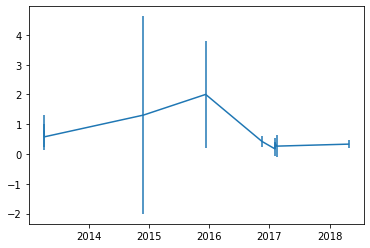

In [115]:
plt.errorbar(outtable['yr'], outtable['pa_offset'], yerr=outtable['pa_offset_err'])

In [116]:
out2 = outtable.drop([2,3])

In [130]:
newplate = 7.906780677 #out2.platescale.mean()
newplateerr = 0.1057254707 #out2.platescale.std()
print('new platescale is: '+str(newplate)+'+/-'+str(newplateerr))
newpa = 0.4104325887 #out2.pa_offset.mean()
newpaerr = 0.1057254707 #out2.pa_offset.std()
print('new pa-off is: '+str(newpa)+'+/-'+str(newpaerr))

new platescale is: 7.906780677+/-0.1057254707
new pa-off is: 0.4104325887+/-0.1057254707


In [155]:
outtable

,epoch,object,sep,sep_err,pa,pa_err,pa_default,sep_default,pa_err_default,sep_err_default,...,pa_offset_err,pa_expected,sep_expected,pa_err_expected,sep_err_expected,pa_newdef,sep_newdef,pa_err_newdef,sep_err_newdef,yr
0,56388.0,1.0,14.724274,0.107122,222.701469,0.388696,222.111469,116.321765,0.491003,0.896041,...,0.549255,221.930526,115.929398,0.672878,1.859121,221.720469,116.910736,0.548501,1.829418,2013.260274
1,56389.0,1.0,14.549567,0.098303,222.511326,0.177892,221.921326,114.941580,0.348777,0.829319,...,0.426759,221.933755,115.929047,0.462351,1.805721,221.530326,115.523563,0.425928,1.780636,2013.263014
2,56990.0,1.0,14.789035,0.277050,225.203971,3.306293,224.613971,116.833379,3.319875,2.208592,...,3.319516,223.895222,115.677418,4.685163,3.378697,224.222971,117.424941,3.328865,2.735962,2014.909589
3,57367.0,1.0,15.121239,0.458726,227.134512,1.793952,226.544512,119.457790,1.818863,3.636535,...,1.809815,225.131280,115.483344,2.548273,5.153859,226.153512,120.062639,1.835220,4.004115,2015.942466
4,57709.0,1.0,14.617388,0.036466,226.681237,0.015062,226.091237,115.477368,0.300378,0.410436,...,0.189254,226.256675,115.282706,0.189853,1.473663,225.700237,116.062064,0.387293,1.633774,2016.877049
5,57788.0,1.0,14.484011,0.052299,226.690009,0.165388,226.100009,114.423689,0.342568,0.504594,...,0.242453,226.516536,115.232626,0.293490,1.533071,225.709009,115.003049,0.420859,1.646466,2017.093151
6,57790.0,1.0,14.457903,0.038578,226.877635,0.047179,226.287635,114.217434,0.303687,0.420115,...,0.183180,226.523157,115.231349,0.189158,1.480907,225.896635,114.795751,0.389865,1.619599,2017.098630
7,57798.0,1.0,14.491549,0.061778,226.815344,0.318754,226.225344,114.483235,0.437726,0.567619,...,0.364046,226.549714,115.226378,0.483874,1.576821,225.834344,115.062897,0.501371,1.667833,2017.120548
8,58234.0,1.0,14.541079,0.126381,228.321249,0.056525,227.731249,114.874527,0.305279,1.039902,...,0.130447,227.988146,114.926327,0.142167,1.996555,227.340249,115.456170,0.391106,1.888227,2018.315068


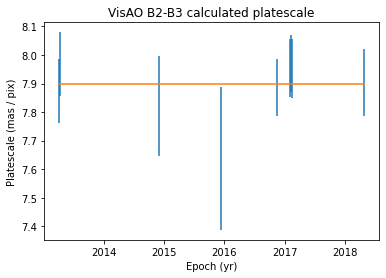

In [140]:
# platescale over time

plt.figure()
plt.errorbar(epochs_yr, outtable['platescale'], yerr=outtable['platescale_err'], ls='none')
plt.plot(epochs_yr, np.zeros_like(outtable['epoch'])+7.9, label='VisAO default = 7.9')
plt.title('VisAO B2-B3 calculated platescale')
plt.xlabel('Epoch (yr)')
plt.ylabel('Platescale (mas / pix)')
plt.savefig('visao_platescale.png', dpi=200)

In [165]:
indivresults = pd.read_csv('VisAO B2-B3 HPF 2.csv')
indivresults.head()

,sep,seperr,PA,PAerr,date,filter
0,14.789035,0.133179,225.203971,3.093105,2014-11-29,SDI-H-alpha
1,14.990280,0.055087,225.369478,1.869850,2014-11-29,SDI-H-alpha
2,14.442560,0.135169,219.561852,3.751624,2014-11-29,SDI-H-alpha
3,14.957795,0.279739,226.834360,4.111459,2015-12-11,SDI-H-alpha
4,15.321156,0.315946,227.439191,4.489308,2015-12-11,SDI-H-alpha


In [166]:
haindiv = indivresults[indivresults['filter']=='SDI-H-alpha']
zindiv = indivresults[indivresults['filter']=='zprime']
yindiv = indivresults[indivresults['filter']=='Ys']
iindiv = indivresults[indivresults['filter']=='iprime']
rindiv = indivresults[indivresults['filter']=='rprime']

In [167]:
timedict = {'2013-04-06':56388,
'2013-04-07':56389,
'2014-11-29':56990,
'2015-12-11':57367,
'2016-11-17':57709,
'2017-02-04':57788,
'2017-02-06':57790,
'2017-02-14':57798,
'2018-04-26':58234}

In [168]:
filters = [haindiv, zindiv, yindiv, iindiv, rindiv]
for filt in filters:
    filt['epoch'] = [timedict[x] for x in filt['date']]

In [169]:
filtdict = {}
filterlist = ['Ha', 'zprime', 'Ys', 'iprime', 'rprime']
i = 0
for filt in filters:
    dates = []
    for day in filt['epoch']:
        if day not in dates:
            dates.append(day)
    datedict = {}
    for date in dates:
        datetab = filt[filt['epoch'] == date]
        sep = np.average(datetab['sep'], weights = 1/datetab['seperr'])
        pa = np.average(datetab['PA'], weights = 1/datetab['PAerr'])
        if len(datetab) == 1:
            seperr = datetab['seperr']
            paerr = datetab['PAerr']
        else:
            seperr = np.std(datetab['sep'])
            paerr = np.std(datetab['PA'])
        datedict[date] = [sep, seperr, pa, paerr]
    filtdict[filterlist[i]] = datedict
    i += 1

In [170]:
expdict = {}
for night in outtable['epoch']:
    yr = Time(night, format='mjd').decimalyear
    nighttab = kekDF[kekDF['epoch'] == yr]
    mjd = Time(night, format='mjd').mjd
    expdict[mjd] = nighttab

[56990, 57367]
[7.8044388882025775, 7.681494876313137]
[56388, 56389, 57709, 57788, 57790, 57798, 58234]
[7.911794824170597, 7.907282647581913, 7.881870968326694, 7.976215322072255, 7.97889781885299, 7.909208275320606, 7.892568462358892]
[56388, 57788]
[7.844564737265486, 7.935589151734961]
[56389, 57709, 57790, 57798]
[7.982265881235916, 7.914938589455423, 7.9709833791464595, 7.967977171241219]
[56389, 58234]
[8.009024409754312, 7.9777492911355665]


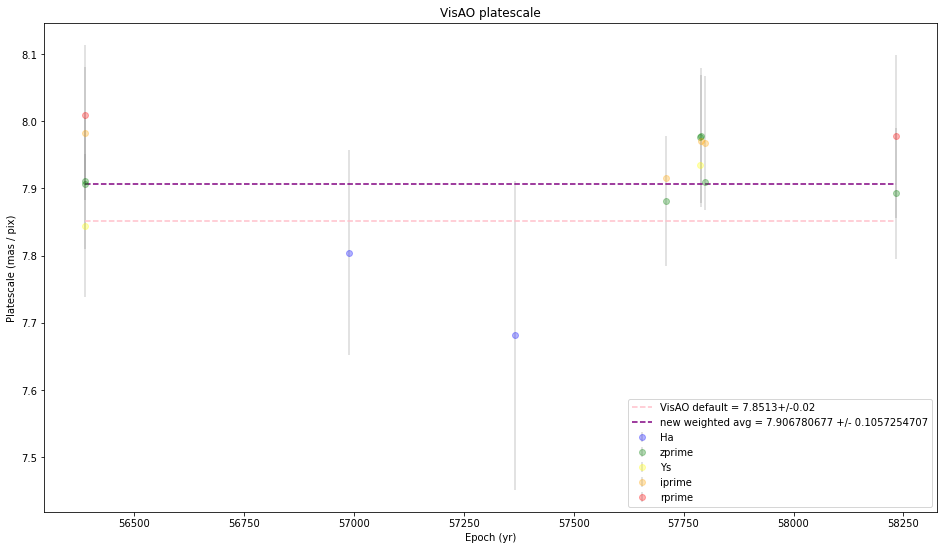

In [172]:
from astropy.time import Time
colors = ['blue', 'green', 'yellow', 'orange', 'red']
c = 0
plt.figure(figsize=(16,9))
for wavel in filtdict.keys():
    filt = filtdict[wavel]
    clor = colors[c]
    filtname = filterlist[c]
    c += 1
    platescalelist = []
    platescalelisterr = []
    nights = []
    for night in filt.keys():
        expvals = expdict[night]
        vals = filt[night]
        sep = vals[0]
        seperr = vals[1]
        nights.append(night)
        platescale = expvals['sep']/sep
        platescalelist.append(platescale.to_list()[0])
        platescale_err = platescale*np.sqrt(((seperr/sep)**2)+((expvals['seperr']/expvals['sep'])**2))
        platescalelisterr.append(platescale_err.to_list()[0])
    print(nights)
    print(platescalelist)
    plt.errorbar(nights, platescalelist, yerr=platescalelisterr, color=clor, ecolor='grey', label=filtname, linestyle='', fmt='o', alpha=0.3)
plt.plot(outtable['epoch'], np.zeros_like(outtable['epoch'])+7.8513, label='VisAO default = 7.8513+/-0.02', linestyle='dashed', color='pink')
newplatelabl = 'new weighted avg = '+str(newplate)+' +/- '+str(newplateerr)
plt.plot(outtable['epoch'], np.zeros_like(outtable['epoch'])+newplate, label=newplatelabl, linestyle='dashed', color='purple')
plt.legend(loc='lower right')
plt.title('VisAO platescale')
plt.xlabel('Epoch (yr)')
plt.ylabel('Platescale (mas / pix)')
plt.savefig('platescale_across epoch.png')

In [126]:
outtable.columns

Index(['epoch', 'object', 'sep', 'sep_err', 'pa', 'pa_err', 'pa_default',
       'sep_default', 'pa_err_default', 'sep_err_default', 'platescale',
       'platescale_err', 'pa_offset', 'pa_offset_err', 'pa_expected',
       'sep_expected', 'pa_err_expected', 'sep_err_expected', 'pa_newdef',
       'sep_newdef', 'pa_err_newdef', 'sep_err_newdef', 'yr'],
      dtype='object')

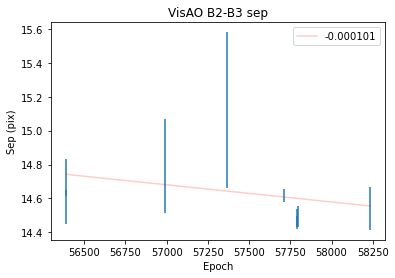

In [151]:
slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], outtable['sep'])
plt.errorbar(outtable['epoch'], outtable['sep'], yerr=outtable['sep_err'], ls='none')
plt.plot(outtable['epoch'], intercept + slope*outtable['epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
# plt.xlim(-500, 6700)
plt.title('VisAO B2-B3 sep')
plt.xlabel('Epoch')
plt.ylabel('Sep (pix)')
plt.savefig('visao_sep_pix.png', dpi=200)